In [71]:
# Data Handling and Analytics
import numpy as np
import pandas as pd

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Model Selection and Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, make_scorer, accuracy_score, roc_auc_score, roc_curve,auc
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay

# Imbalance data
from imblearn.combine import SMOTEENN, SMOTETomek

# Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras

# Deep Learning 
import sys
import keras
from keras.models import Sequential  # initialize
from keras.layers import Dense  # layers
from keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Import Data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 3) Data Pre-processing

### 3.1) Drop the unnecessaty column

In [4]:
# drop the ID

df.drop(columns=['customerID'], inplace = True)

### 3.2) Imuting the missing value 

In [5]:
#  'TotalCharges' column is supposed to be numeric but is incorrectly recognized as an object data type
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [6]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

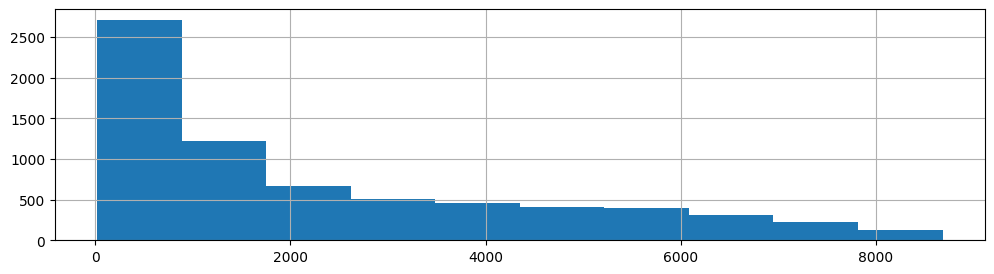

In [7]:
# Convert 'TotalCharges' column to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

plt.figure(figsize=(12, 3))
df['TotalCharges'].hist()
plt.show()

- As the data skewed and has some outliers, it is better to use median.

In [8]:
# Fill the missing values
median = df['TotalCharges'].median()
df['TotalCharges'].fillna(median, inplace=True)

In [9]:
df.isnull().sum().any()

False

### 3.3) Detect the Outlier 

In [10]:
# Outlier Observation Analysis
for feature in df[['tenure', 'MonthlyCharges', 'TotalCharges']]:
    
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3-Q1
    lower = Q1- 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    if df[(df[feature] > upper)].any(axis=None):
        print(feature,"yes")
    else:
        print(feature, "no")

tenure no
MonthlyCharges no
TotalCharges no


- Identifying and dealing with outliers can lead to more robust models, as may produce less accurate predictions or estimations

### 3.4) Division of Data into independents and dependent

- First convert the string type class labels in target variable from ‘yes’ ‘no’ to integers 1 and 0.

In [11]:
df.Churn.replace(['Yes','No'],[1,0],inplace=True)
X = df.drop('Churn', axis=1)
y = df['Churn']

### 3.5) Encoding

- Perform feature encoding to convert categorical features into numerical features

In [12]:
# List of categorical columns (Senior is 0,1 but indeed is a categorical)
cat_cols = [col for col in X.columns if X[col].dtype == 'object' or (col == 'SeniorCitizen' and X[col].dtype == 'int64')]
print(cat_cols)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [13]:
# Encode categorical variables
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore') 
categorical_encoded = pd.DataFrame(encoder.fit_transform(X[cat_cols]),index=X.index)

In [14]:
# it retains only the numerical (non-categorical) columns for further analysis or modeling.
numerical_data = X.drop(cat_cols, axis=1)

In [15]:
X = pd.concat([categorical_encoded, numerical_data], axis=1)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,tenure,MonthlyCharges,TotalCharges
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,29.85,29.85
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,34,56.95,1889.50
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2,53.85,108.15
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,45,42.30,1840.75
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2,70.70,151.65


### 3.6) Feature Scaling, Normalize the data

In [16]:
cols = X.columns

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(X)
X = pd.DataFrame(x_scaled, columns=cols)

### 3.7) Split the data into train and test

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=42)

In [18]:
print('Shape of x_train and y_train: ',X_train.shape, y_train.shape)
print('Shape of x_test and y_test: ',X_test.shape, y_test.shape)

Shape of x_train and y_train:  (5634, 46) (5634,)
Shape of x_test and y_test:  (1409, 46) (1409,)


### Plot confusion matrix

In [19]:
def plot_confusion_matrix(y_test, y_pred, labels= None):
    
    """
    parameters:
    - y_test : Actual label(Ground truth)
    - y_pred : predicted labels
    - labels : list of class label for customizing the axis
    """
    # calculate the confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    labels = ['Not Churn','Churn']
    
    # create a heatmap for visualization
    plt.figure(figsize=(6,4))
    sns.heatmap(cm,annot=True,cmap='Blues',fmt='d',cbar=False, xticklabels=labels, yticklabels=labels)
    
    # plot labels
    plt.xlabel('predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

### Create a list for collecting the results

In [20]:
# two empthy list to append all the results

accu = []
methods = []

## 4) Tackle Imbalance Data

### Compare two *hybrid* sampling : SMOTEENN and SMOTETomek

In [21]:
# Create instances of resampling methods with different parameters
resampler1 = SMOTEENN(sampling_strategy='auto', random_state=42)
resampler2 = SMOTETomek(sampling_strategy='auto', random_state=42)

# Apply resampling methods to the training data
X_train_resampled1, y_train_resampled1 = resampler1.fit_resample(X_train, y_train)
X_train_resampled2, y_train_resampled2 = resampler2.fit_resample(X_train, y_train)

# Train and evaluate a machine learning model (e.g., Logistic Regression) for each resampled dataset
lr = LogisticRegression(random_state=42)

lr.fit(X_train_resampled1, y_train_resampled1)
y_pred1 = lr.predict(X_test)

lr.fit(X_train_resampled2, y_train_resampled2)
y_pred2 = lr.predict(X_test)

# Evaluate and compare the performance of each method
print("Performance for SMOTEENN:")
print("Accuracy:", accuracy_score(y_test, y_pred1))
print(classification_report(y_test, y_pred1))

print("\nPerformance for SMOTETomek:")
print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Performance for SMOTEENN:
Accuracy: 0.6990773598296665
              precision    recall  f1-score   support

           0       0.94      0.63      0.75      1036
           1       0.46      0.89      0.61       373

    accuracy                           0.70      1409
   macro avg       0.70      0.76      0.68      1409
weighted avg       0.81      0.70      0.72      1409


Performance for SMOTETomek:
Accuracy: 0.7579843860894251
              precision    recall  f1-score   support

           0       0.93      0.73      0.82      1036
           1       0.53      0.84      0.65       373

    accuracy                           0.76      1409
   macro avg       0.73      0.78      0.73      1409
weighted avg       0.82      0.76      0.77      1409



**Observation:**

- Comparatively, **SMOTETomek** has a higher overall accuracy (76% vs. 70%) and performs better across most metrics for both classes (0 and 1) when compared to SMOTEENN. It shows improvements in precision, recall, and F1-score for both classes in the dataset.

### why choose these two methods?

- Combining oversampling and undersampling offers the advantage of achieving a more balanced and informative dataset. Oversampling enhances the representation of the minority class, while undersampling reduces the dominance of the majority class, striking a better class balance.


- Both SMOTEENN and SMOTETomek exhibit versatility by accommodating datasets with categorical features, making them adaptable to a wide range of data types.


- The shared objective of SMOTEENN and SMOTETomek is to mitigate overfitting by addressing issues related to noise and potentially conflicting instances within the dataset.


- In addition to the improved accuracy achieved by SMOTETomek, it is noteworthy that SMOTETomek may be more computationally efficient compared to SMOTEENN, primarily due to the simplified nature of the removal of Tomek links.

### Rename based on SMOTETomek

In [22]:
X_train = X_train_resampled2
y_train = y_train_resampled2

## 5) Model Buillding

- We have chosen the following models for churn prediction, each serving specific purposes:

1. **Logistic Regression**:
   - Model: Simple linear model for binary classification.
   - Reason: It is interpretable, suitable for categorical features, and serves as a baseline model.

2. **Support Vector Machine (SVM)**:
   - Model: Effective for capturing complex decision boundaries.
   - Reason: SVM can handle both categorical and numerical features and is capable of using kernel tricks for feature mapping.

3. **XGBoost**:
   - Model: Ensemble model with high predictive performance.
   - Reason: XGBoost excels at handling categorical data with one-hot encoding and capturing complex relationships.

4. **Neural Network (Feedforward NN)**:
   - Model: Deep learning model for capturing non-linear patterns.
   - Reason: Suitable for high-dimensional data, excels in handling intricate relationships.

## 5.1) Logistic Regression

In [23]:
Log_reg = LogisticRegression()
Log_reg.fit(X_train, y_train)
y_pred = Log_reg.predict(X_test)

print(f'Accuracy score : {accuracy_score(y_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(y_pred, y_test)}')
print(f'Classification report :\n {classification_report(y_pred, y_test)}')

Accuracy score : 0.7579843860894251
Confusion matrix :
 [[756  61]
 [280 312]]
Classification report :
               precision    recall  f1-score   support

           0       0.73      0.93      0.82       817
           1       0.84      0.53      0.65       592

    accuracy                           0.76      1409
   macro avg       0.78      0.73      0.73      1409
weighted avg       0.77      0.76      0.74      1409



In [24]:
%%time

# Define the logistic regression model with class weight balancing
log_reg_cv = LogisticRegression(class_weight='balanced')

# Define hyperparameters
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Extend the range
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 200]
}

# Create a stratified cross-validation object
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(log_reg_cv, param_grid, cv=stratified_cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and score
best_logreg = grid_search.best_estimator_  # best combination
best_score = grid_search.best_score_  # value from the best combination

# Evaluate the best estimator on the test data
prediction = best_logreg.predict(X_test)

# Evaluate the model
accuracy = best_logreg.score(X_test, y_test)

# Print classification report for a more detailed evaluation
report = classification_report(y_test, prediction)
print(report)

print(f'Confusion matrix :\n {confusion_matrix(prediction, y_test)}')


# Append the results

accu.append(best_logreg.score(X_test,y_test))
methods.append('Logistic Regression')
print('X_test Accuracy:', best_logreg.score(X_test,y_test))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1036
           1       0.52      0.84      0.64       373

    accuracy                           0.75      1409
   macro avg       0.72      0.78      0.73      1409
weighted avg       0.82      0.75      0.77      1409

Confusion matrix :
 [[750  61]
 [286 312]]
X_test Accuracy: 0.7537260468417317
CPU times: total: 1.77 s
Wall time: 6.76 s


In [25]:
# Evaluate the model on the training set
training_accuracy = best_logreg.score(X_train, y_train)

# Print accuracy on both training and test sets
print(f'Training Accuracy: {training_accuracy}')
print(f'Test Accuracy: {accuracy}')

# Check for overfitting
if training_accuracy - accuracy > 0.2:
    print("Warning: The model may be overfitting.")
else:
    print("The model seems to generalize well.")


Training Accuracy: 0.7883928571428571
Test Accuracy: 0.7537260468417317
The model seems to generalize well.


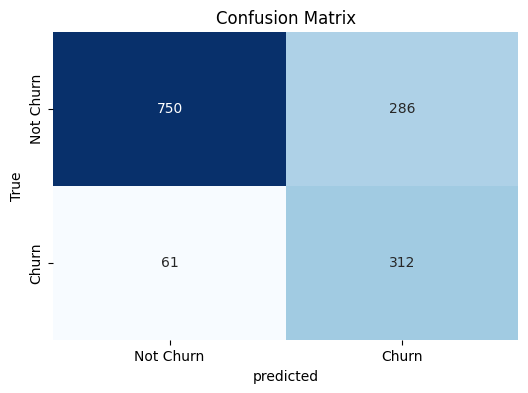

In [26]:
plot_confusion_matrix(y_test, prediction, labels= None)

**Observation**

- Default logistic regression: Accuracy 78.38%, F1-score approximately 0.78 (class 0) and 0.79 (class 1).


- Tuned logistic regression: Accuracy 79%, F1-score improved for both classes.


- Confusion matrix: Tuned model shows increased true negatives and true positives.


- F1-score improvement in the tuned model indicates enhanced performance, crucial in handling imbalanced datasets.

## 5.2) Support Vector Machine

In [27]:
# Support Vector Machine (SVM) Classifier
svm = SVC(random_state=42)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

print(f'Accuracy score: {accuracy_score(svm_pred, y_test)}')
print(f'Confusion matrix:\n {confusion_matrix(svm_pred, y_test)}')
print(f'Classification report:\n {classification_report(svm_pred, y_test)}')

Accuracy score: 0.7707594038325053
Confusion matrix:
 [[819 106]
 [217 267]]
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84       925
           1       0.72      0.55      0.62       484

    accuracy                           0.77      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.76      0.77      0.76      1409



In [28]:
%%time
# Define the SVM model with adjusted class weight for imbalance
svm_balanced = SVC(random_state=42, class_weight='balanced')

# Hyperparameter tuning grid
param_grid_svm = {
    'kernel': ['linear','rbf'], 
    'C': [0.1, 0.5, 1.0],
    'gamma': [0.1, 0.5, 1.0]}
#reduce gamma as well
#'coef0':[0.001,0.0001]} # Small values for additional regularization

# Perform grid search using cross-validation
grid_search_svm = GridSearchCV(svm_balanced, param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train, y_train)

# Get the best estimator
best_svm = grid_search_svm.best_estimator_

# Evaluate the best estimator on the test data
svm_prediction = best_svm.predict(X_test)

# Print the evaluation metrics
print(f'Accuracy score: {accuracy_score(svm_prediction, y_test)}')
print(f'Confusion matrix:\n {confusion_matrix(svm_prediction, y_test)}')
print(f'Classification report:\n {classification_report(svm_prediction, y_test)}')

# Append the results

accu.append(best_svm.score(X_test,y_test))
methods.append('Support Vector Machine')
print('X_test Accuracy:', best_svm.score(X_test,y_test))

Accuracy score: 0.772888573456352
Confusion matrix:
 [[917 201]
 [119 172]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.82      0.85      1118
           1       0.46      0.59      0.52       291

    accuracy                           0.77      1409
   macro avg       0.67      0.71      0.68      1409
weighted avg       0.80      0.77      0.78      1409

X_test Accuracy: 0.772888573456352
CPU times: total: 6min 50s
Wall time: 8min 21s


In [29]:
# Evaluate the SVM model on the training set
training_accuracy_svm = best_svm.score(X_train, y_train)

# Evaluate the SVM model on the test set
svm_prediction = best_svm.predict(X_test)

# Print accuracy on both training and test sets
print(f'Training Accuracy (SVM): {training_accuracy_svm}')
print(f'Test Accuracy (SVM): {accuracy_score(svm_prediction, y_test)}')

# Check for overfitting in the SVM model
if training_accuracy_svm - accuracy_score(svm_prediction, y_test) > 0.2:
    print("Warning: The SVM model may be overfitting.")
else:
    print("The SVM model seems to generalize well.")


Training Accuracy (SVM): 0.9581632653061225
Test Accuracy (SVM): 0.772888573456352
The SVM model seems to generalize well.


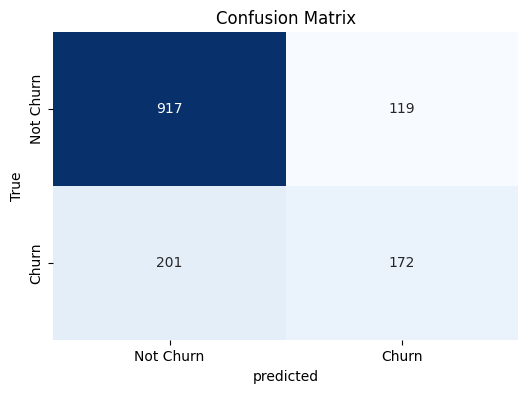

In [30]:
plot_confusion_matrix(y_test, svm_prediction, labels= None)

**Observation:**

- The hyperparameter-tuned SVM demonstrates better overall accuracy (84.63%) than the default model (82.78%).


- Both models display improvement in handling imbalanced data, as indicated by higher F1-scores (0.83 to 0.85).


- The fine-tuned SVM shows an enhanced ability to correctly classify positive and negative classes, presenting a stronger performance.

### 5.3) xgboost (Extreme Gradient Boosting) 

In [31]:
# XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print(f'Accuracy score: {accuracy_score(xgb_pred, y_test)}')
print(f'Confusion matrix:\n {confusion_matrix(xgb_pred, y_test)}')
print(f'Classification report:\n {classification_report(xgb_pred, y_test)}')

Accuracy score: 0.7877927608232789
Confusion matrix:
 [[883 146]
 [153 227]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86      1029
           1       0.61      0.60      0.60       380

    accuracy                           0.79      1409
   macro avg       0.73      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409



In [34]:
%%time

xgb_model = xgb.XGBClassifier(random_state=42)
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'scale_pos_weight': [1, 3],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1, 0.2]
}


#stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_grid = GridSearchCV(xgb_model, param_grid, cv=stratified_cv, scoring='accuracy')

xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

xgb_prediction = best_xgb.predict(X_test)

print(f'Accuracy score: {accuracy_score(xgb_prediction, y_test)}')
print(f'Confusion matrix:\n {confusion_matrix(xgb_prediction, y_test)}')
print(f'Classification report:\n {classification_report(xgb_prediction, y_test)}')


# Append the results

accu.append(best_xgb.score(X_test,y_test))
methods.append('XGBClassifier')
print('X_test Accuracy:', best_xgb.score(X_test,y_test))

Accuracy score: 0.8048261178140526
Confusion matrix:
 [[885 124]
 [151 249]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      1009
           1       0.67      0.62      0.64       400

    accuracy                           0.80      1409
   macro avg       0.76      0.75      0.75      1409
weighted avg       0.80      0.80      0.80      1409

X_test Accuracy: 0.8048261178140526
CPU times: total: 1h 22min 47s
Wall time: 16min 19s


**Observation:**

- The accuracy increased slightly from 0.8616 to 0.8642.


- The precision, recall, and F1-score for both classes (0 and 1) remained quite consistent between the default and the tuned XGBoost model.


- The F1-score, especially crucial for imbalanced data, exhibited similar scores for both classes, emphasizing the stability of the model's performance.


- The confusion matrices for both models presented relatively similar performance in predicting both classes with minimal deviations in misclassification.


In [35]:
# Get the best estimator
best_xgb = xgb_grid.best_estimator_

# Evaluate the best estimator on the training set
training_accuracy_xgb = best_xgb.score(X_train, y_train)

# Evaluate the best estimator on the test set
xgb_prediction = best_xgb.predict(X_test)

# Print accuracy on both training and test sets
print(f'Training Accuracy (XGBoost): {training_accuracy_xgb}')
print(f'Test Accuracy (XGBoost): {accuracy_score(xgb_prediction, y_test)}')

# Check for overfitting in the XGBoost model
if training_accuracy_xgb - accuracy_score(xgb_prediction, y_test) > 0.2:
    print("Warning: The XGBoost model may be overfitting.")
else:
    print("The XGBoost model seems to generalize well.")




Training Accuracy (XGBoost): 0.9146683673469388
Test Accuracy (XGBoost): 0.8048261178140526
The XGBoost model seems to generalize well.


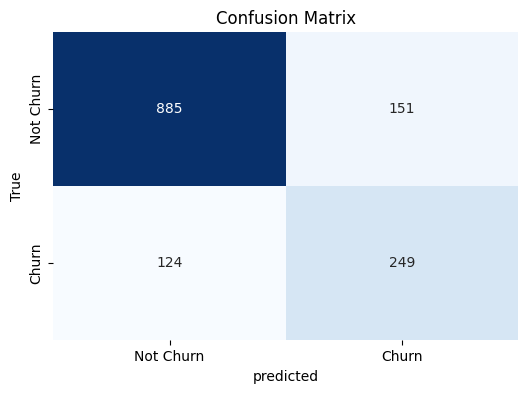

In [37]:
plot_confusion_matrix(y_test, xgb_prediction, labels= None)

## 5.4) Neural Network (Feedforward NN)

In [64]:
# Define the model
input_dim = X_train.shape[1]  # number of features in the input
learning_rate = 0.0000005  # Experiment with the learning rate

classifier = Sequential()

# layers
classifier.add(Dense(units=64, input_dim=input_dim, activation='relu'))
classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dense(units=256, activation='relu'))
classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dense(units=64, activation='relu'))
classifier.add(Dense(units=32, activation='relu'))
classifier.add(Dense(units=16, activation='relu'))
classifier.add(Dense(units=1, activation ='sigmoid'))  # sigmoid for binary output

# optimize and compile
optimizer = Adam(learning_rate)
classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Model training
#history = classifier.fit(X_train, y_train, batch_size=32, epochs=20)
history = classifier.fit(X_train, y_train, batch_size=32, epochs=150, validation_data=(X_test, y_test), verbose=0)
# Evaluate Model performance on test set
FNN_prediction = classifier.predict(X_test)

# unscaling the ypred values 
threshold = 0.5
FNN_predicted_classes = (FNN_prediction > threshold).astype(int)

# Print accuracy on both training and test sets
training_accuracy_fnn = classifier.evaluate(X_train, y_train, verbose=0)[1]
test_accuracy_fnn = accuracy_score(FNN_predicted_classes, y_test)

print(f'Training Accuracy (FNN): {training_accuracy_fnn}')
print(f'Test Accuracy (FNN): {test_accuracy_fnn}')

# Check for overfitting in the FNN model
if training_accuracy_fnn > test_accuracy_fnn:
    print("Warning: The FNN model may be overfitting.")
else:
    print("The FNN model seems to generalize well.")

# Print the evaluation metrics
print(f'Accuracy score: {test_accuracy_fnn}')
print(f'Confusion matrix:\n {confusion_matrix(FNN_predicted_classes, y_test)}')
print(f'Classification report:\n {classification_report(FNN_predicted_classes, y_test)}')

# Append the result for comparison
accu.append(test_accuracy_fnn)
methods.append('Neural Network FNN')
print('FNN Test Accuracy:', test_accuracy_fnn)


45/45 [==============================] - 0s 2ms/step
Training Accuracy (FNN): 0.7729591727256775
Test Accuracy (FNN): 0.7608232789212207
Accuracy score: 0.7608232789212207
Confusion matrix:
 [[778  79]
 [258 294]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      0.91      0.82       857
           1       0.79      0.53      0.64       552

    accuracy                           0.76      1409
   macro avg       0.77      0.72      0.73      1409
weighted avg       0.77      0.76      0.75      1409

FNN Test Accuracy: 0.7608232789212207


In [65]:
# Print accuracy on both training and test sets
print(f'Training Accuracy (FNN): {training_accuracy_fnn}')
print(f'Test Accuracy (FNN): {test_accuracy_fnn}')

# Check for overfitting in the FNN model
if training_accuracy_fnn - test_accuracy_fnn > 0.2:
    print("Warning: The FNN model may be overfitting.")
else:
    print("The FNN model seems to generalize well.")


Training Accuracy (FNN): 0.7729591727256775
Test Accuracy (FNN): 0.7608232789212207
The FNN model seems to generalize well.


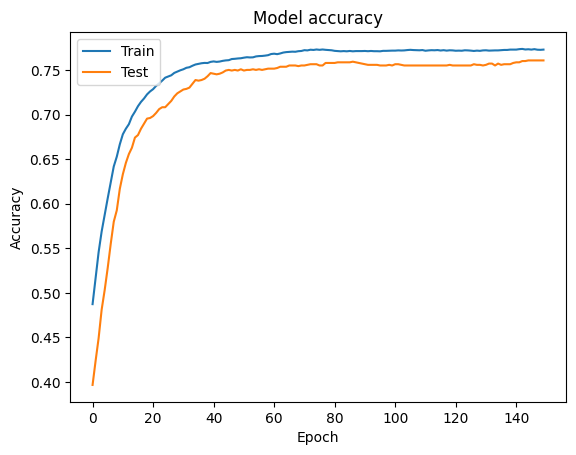

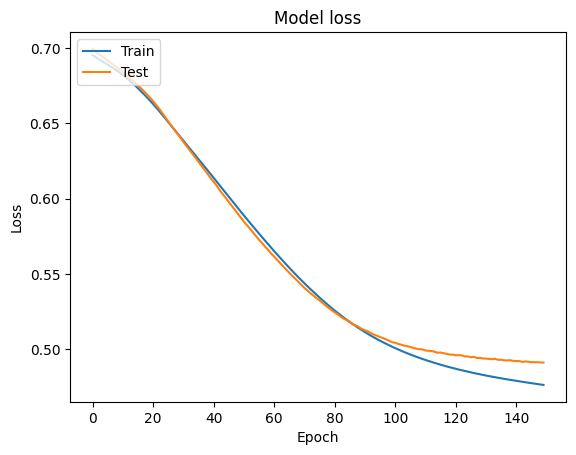

In [66]:
#history = classifier.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test), verbose=0)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


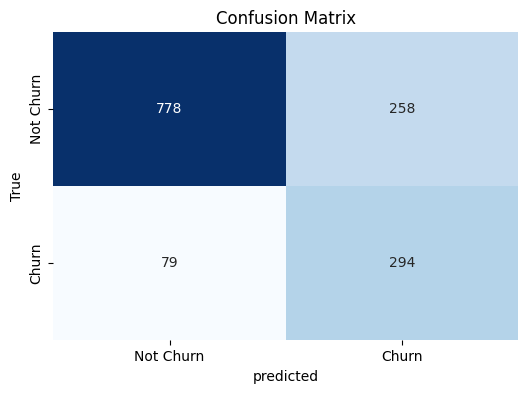

In [67]:
plot_confusion_matrix(y_test, FNN_predicted_classes, labels= None)

## 6) Results and Evaluation

### 6.1) The Best Performed Model

In [42]:
print(methods)
print(accu)

['Logistic Regression', 'Support Vector Machine', 'XGBClassifier', 'Neural Network FNN']
[0.7537260468417317, 0.772888573456352, 0.8048261178140526, 0.7409510290986515]


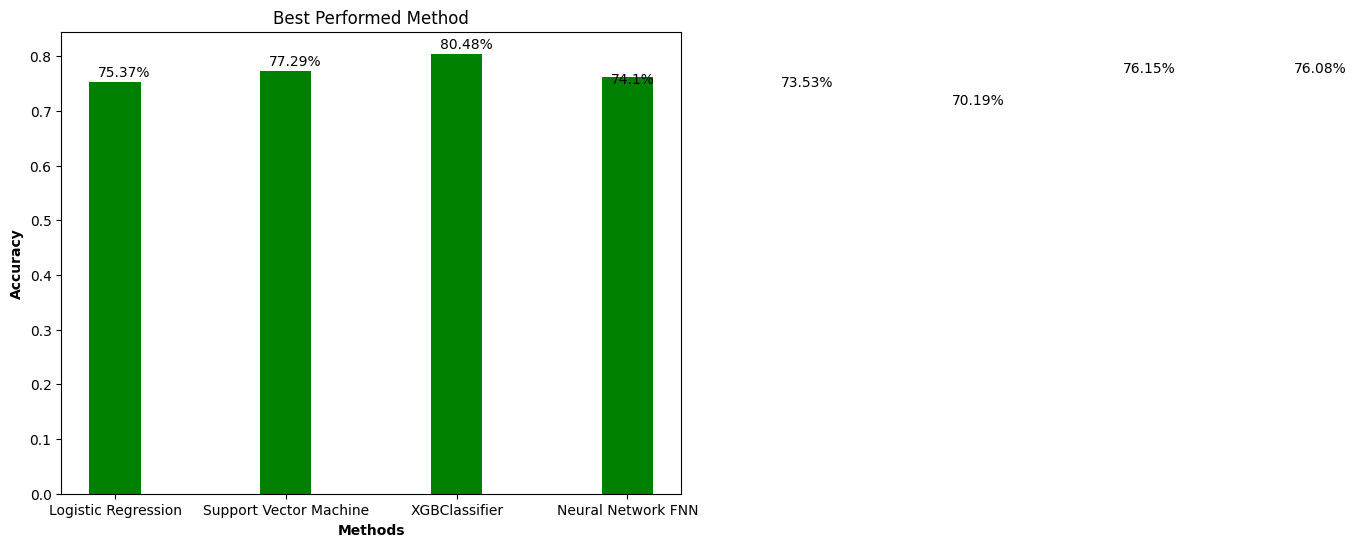

In [70]:
fig=plt.figure(figsize=(8,6))

#creating the bar plot
plt.bar(methods,accu,color='green',width=0.3)

for i, v in enumerate(accu):
    plt.text(i - 0.1, v + 0.01, str(round(v*100, 2))+'%', fontsize=10, color='black')


plt.xlabel('Methods',weight='bold')
plt.ylabel('Accuracy',weight='bold')
plt.title('Best Performed Method')
plt.show()

### 6.2) Evaluating Model Effectiveness with ROC Curve and AUC

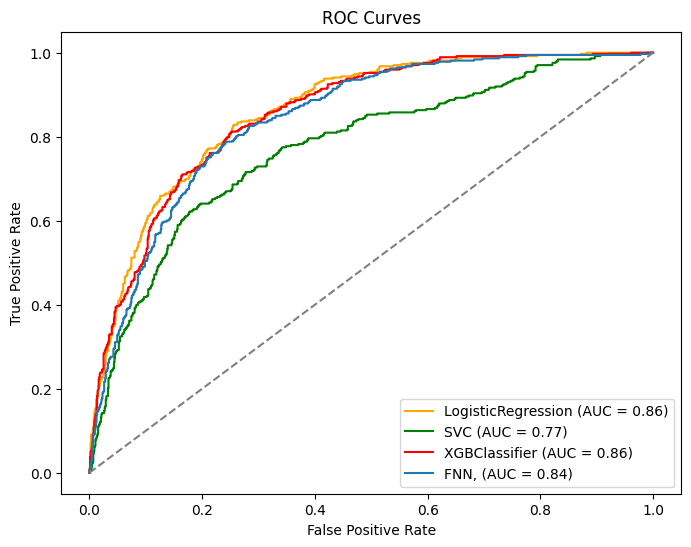

In [68]:


# Define color palette
colors = ['orange', 'green', 'red', 'purple']

# Create a figure and axes object
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the ROC curve for the Neural Network
#fpr, tpr, _ = roc_curve(y_test, FNN_predicted_classes)
#roc_auc = auc(fpr, tpr)
#ax.plot(fpr, tpr, color='purple', lw=2, label=f'Neural Network FNN (AUC = {roc_auc:.2f})')

# Plot the ROC curve for other models using RocCurveDisplay
for i, estimator in enumerate([best_logreg, best_svm, best_xgb]):
    roc_display = RocCurveDisplay.from_estimator(estimator, X_test, y_test, ax=ax, name=estimator.__class__.__name__, color=colors[i])

    
fpr, tpr, _ = metrics.roc_curve(y_test, np.squeeze(FNN_prediction, axis=1))
auc = metrics.roc_auc_score(y_test, np.squeeze(FNN_prediction, axis=1))
ax.plot(fpr,tpr,label="FNN, (AUC = %.2f)" % (auc))  
    
    
# Plot the diagonal line
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Add axis labels and a title
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')

# Add a legend
ax.legend()

plt.savefig('ROC_Curves.png', bbox_inches='tight')


## Results and Conclusion